# Fruit Classification using Transfer Learning

This project implements a deep learning model for fruit image classification using transfer learning with the VGG16 architecture.

## Environment Setup

Configure the environment by suppressing unnecessary warnings to keep the output clean and focused on important information.

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.dataset_utils")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info messages

## Dataset Preparation

Download and extract the Fruits-360 dataset. The dataset contains fruit images organized into training, validation, and test sets. The extraction process handles large files efficiently by processing them in batches.

In [2]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")

Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


## Library Imports and Path Configuration

Import all necessary libraries for deep learning, image processing, and visualization. Define the paths to the training, validation, and test directories.

In [3]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Set dataset paths (relative to notebook location in notebooks/ directory)
train_dir = './fruits-360-original-size/fruits-360-original-size/Training'
val_dir = './fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = './fruits-360-original-size/fruits-360-original-size/Test'

## Data Generators Setup

Create data generators that load images from directories and apply preprocessing. For training data, we apply augmentation techniques (rotation, shifting, zooming, flipping) to increase dataset diversity and improve model generalization. Validation and test sets only require rescaling to normalize pixel values.

In [4]:
# Configure data generators with augmentation for training
# Training data: apply augmentation to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data: only rescale (no augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.
Training samples: 6231
Validation samples: 3114
Test samples: 3110
Number of classes: 24


## Model Architecture

Build the classification model using transfer learning with VGG16. The pre-trained VGG16 model (trained on ImageNet) serves as the feature extractor. We freeze its layers to preserve the learned weights and add custom classification layers on top. The architecture includes global average pooling, dense layers with batch normalization and dropout for regularization.

In [5]:
# Build model using VGG16 as base with transfer learning
# Load pre-trained VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze base model layers to preserve pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduces spatial dimensions
    Dense(256, activation='relu'),
    BatchNormalization(),  # Stabilizes training
    Dropout(0.3),  # Prevents overfitting
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,853,208 (56.66 MB)

 Trainable params: 138,008 (539.09 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

## Model Compilation

Compile the model with categorical cross-entropy loss (suitable for multi-class classification) and the Adam optimizer. Accuracy is used as the evaluation metric.

In [6]:
# Compile model with appropriate loss and optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Initial Training

Train the model with frozen base layers. We use callbacks to optimize training:
- **ReduceLROnPlateau**: Automatically reduces learning rate when validation loss plateaus
- **EarlyStopping**: Stops training if validation loss doesn't improve, preventing overfitting

This initial training phase allows the custom classification layers to learn fruit-specific features while leveraging the pre-trained VGG16 feature extractor.

In [7]:
# Configure training callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.1555 - loss: 3.1891 - val_accuracy: 0.2000 - val_loss: 2.7238 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4351 - loss: 1.8785 - val_accuracy: 0.4125 - val_loss: 2.0453 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.5927 - loss: 1.2957 - val_accuracy: 0.5225 - val_loss: 1.7369 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6706 - loss: 1.1222 - val_accuracy: 0.6425 - val_loss: 1.3495 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6762 - loss: 1.0138 - val_accuracy: 0.6675 - val_loss: 1.1385 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


## Fine-Tuning

Fine-tune the model by unfreezing the last few layers of the VGG16 base model. This allows the model to adapt the pre-trained features specifically for fruit classification. We use a lower learning rate to make gradual adjustments without disrupting the learned features. Batch normalization layers remain frozen to maintain training stability.

In [8]:
# Fine-tune model by unfreezing last layers of base model
# Unfreeze last 5 layers for fine-tuning
num_layers = len(base_model.layers)
print(f"Base model has {num_layers} layers")

for layer in base_model.layers[-5:]:
    layer.trainable = True

# Keep BatchNorm layers frozen for stability
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Base model has 19 layers
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.7071 - loss: 0.8708 - val_accuracy: 0.6725 - val_loss: 0.9531 - learning_rate: 1.0000e-05
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8037 - loss: 0.6366 - val_accuracy: 0.7375 - val_loss: 0.7659 - learning_rate: 1.0000e-05
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8259 - loss: 0.6081 - val_accuracy: 0.7925 - val_loss: 0.5978 - learning_rate: 1.0000e-05
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8183 - loss: 0.6041 - val_accuracy: 0.7875 - val_loss: 0.5739 - learning_rate: 1.0000e-05
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.8561 - loss: 0.4931 - val_accuracy: 0.8575 - val_loss: 0.4423 - learning_rate: 1.0000e-05
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8636 - loss: 0.5050 - val_accuracy: 0.8700 - val_loss: 0.4365 - learning_rate: 1.0000e-05
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 6

## Model Evaluation

Evaluate the trained model on the test set to assess its performance on unseen data. This provides an unbiased estimate of the model's generalization capability.

In [9]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Save the trained model
import os
os.makedirs('../models', exist_ok=True)
model.save('../models/fruit_classifier.keras')
print("Model saved to ../models/fruit_classifier.keras")

# Save class indices mapping
import json
class_indices = train_generator.class_indices
# Invert the dictionary so numbers map to names: {0: 'Apple', 1: 'Banana'}
label_map = {v: k for k, v in class_indices.items()}

# Save it to a file
os.makedirs('../config', exist_ok=True)
with open('../config/class_indices.json', 'w') as f:
    json.dump(label_map, f, indent=2)
print("Class indices saved to ../config/class_indices.json")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9311 - loss: 0.2539

Test Accuracy: 0.9325 (93.25%)
Test Loss: 0.2525
Model saved to ../models/fruit_classifier.keras
Class indices saved to ../config/class_indices.json


## Training Visualization

Visualize the training progress by plotting accuracy and loss curves for both the initial training and fine-tuning phases. These plots help identify overfitting, underfitting, and the effectiveness of the training process.

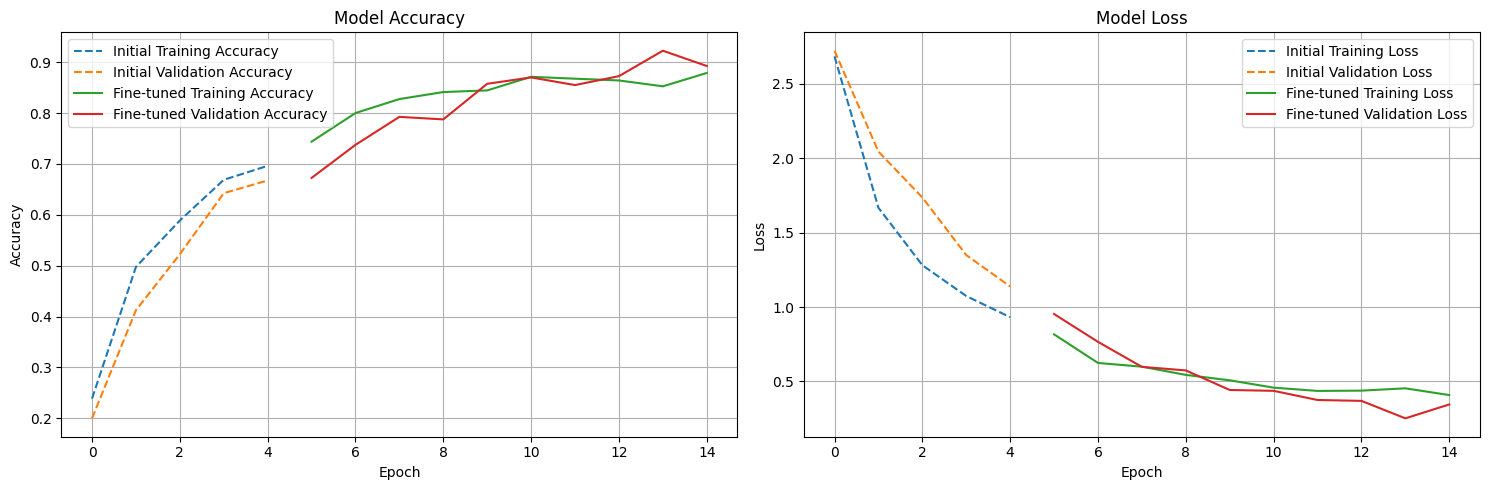

In [10]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Initial Training Accuracy', linestyle='--')
axes[0].plot(history.history['val_accuracy'], label='Initial Validation Accuracy', linestyle='--')
axes[0].plot([x + len(history.history['accuracy']) for x in range(len(history_fine.history['accuracy']))],
             history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
axes[0].plot([x + len(history.history['val_accuracy']) for x in range(len(history_fine.history['val_accuracy']))],
             history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Initial Training Loss', linestyle='--')
axes[1].plot(history.history['val_loss'], label='Initial Validation Loss', linestyle='--')
axes[1].plot([x + len(history.history['loss']) for x in range(len(history_fine.history['loss']))],
             history_fine.history['loss'], label='Fine-tuned Training Loss')
axes[1].plot([x + len(history.history['val_loss']) for x in range(len(history_fine.history['val_loss']))],
             history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Prediction Testing

Test the model on sample images from the test set. For each image, we display the true label, predicted label, and prediction confidence. This provides a visual assessment of the model's performance on individual examples.

Testing model predictions on sample images:



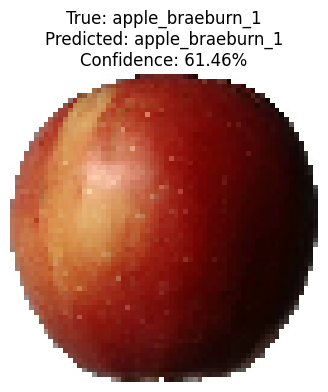

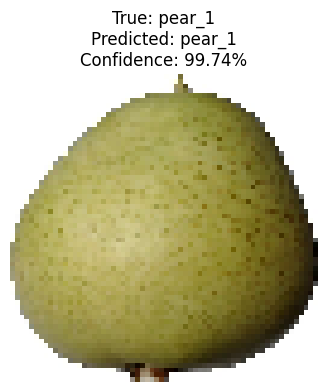

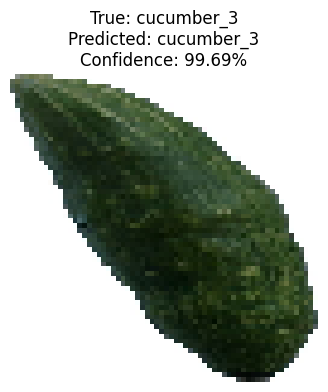

In [11]:
# Test predictions on sample images
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from collections import Counter

# Get class index mapping
class_index_mapping = train_generator.class_indices
index_to_class = {v: k for k, v in class_index_mapping.items()}

def predict_and_visualize(img_path):
    """Load image, make prediction, and display results."""
    # Extract true label from directory structure
    true_class = os.path.basename(os.path.dirname(img_path))

    # Load and preprocess image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class = index_to_class[predicted_index]
    confidence = prediction[0][predicted_index]

    # Display results
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()

    return true_class, predicted_class, confidence

# Test on sample images (paths relative to notebook location)
sample_images = [
    './fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    './fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    './fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg'
]

print("Testing model predictions on sample images:\n")
for img_path in sample_images:
    if os.path.exists(img_path):
        predict_and_visualize(img_path)
    else:
        print(f"Image not found: {img_path}")